# MNIST

In this chapter, we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Cen‐ sus Bureau. Each image is labeled with the digit it represents. This set has been stud‐ ied so much that it is often called the “Hello World” of Machine Learning

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(70000, 784) (70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

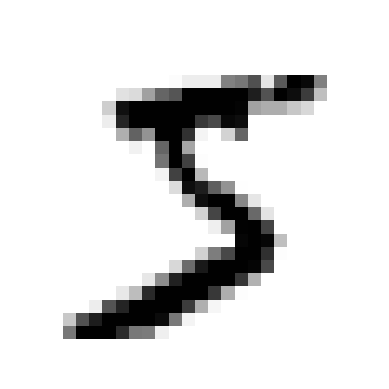

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis('off')

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [4]:
y[0]

'5'

In [5]:
import numpy as np
# cast string to int
y = y.astype(np.uint8)

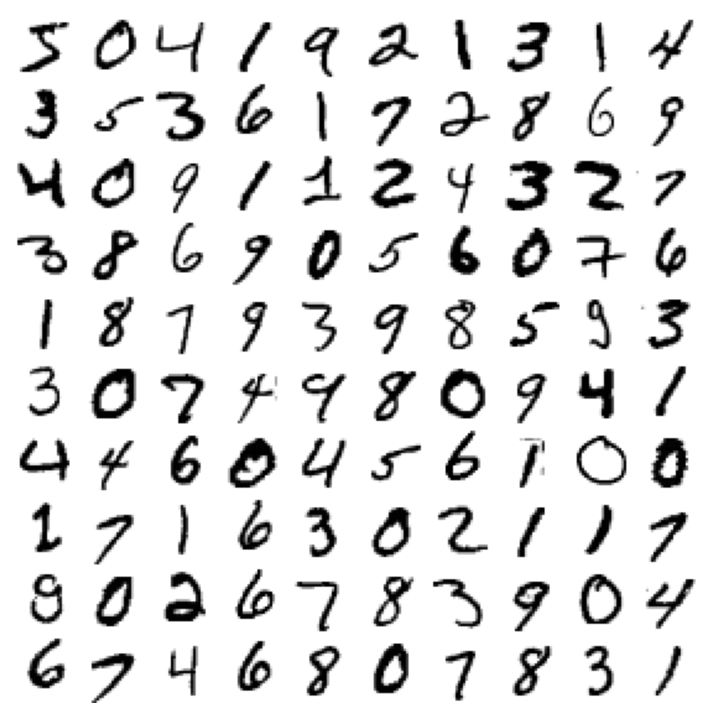

In [6]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis('off')

plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [7]:
# create a test set, MNIST already parepared the data, first 60,000 is for training, last 10,000 is for testing
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5.

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [20]:
# implementing cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
sgd_clf = SGDClassifier(random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold) 
    print(n_correct / len(y_pred)) # accuracy

0.9669
0.91625
0.96785


In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

A dumb classifier that just classifies every single image in the “not-5” class will have 90% accuracy. This is because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets.

## Confusion Matrix

In [36]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [51]:
np.array([['true negative', 'false positive'], ['false negative', 'true positive']])

array([['true negative', 'false positive'],
       ['false negative', 'true positive']], dtype='<U14')

## Precision and Recall

$\text{precision} = \frac{TP}{TP+FP}$ \
$\text{recall} = \frac{TP}{TP+FN}$

In [41]:
from sklearn.metrics import precision_score, recall_score
print('precision: ', precision_score(y_train_5, y_train_pred))
print('recall: ', recall_score(y_train_5, y_train_pred))

precision:  0.8370879772350012
recall:  0.6511713705958311


Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 80% of the time. More‐ over, it only detects 65% of the 5s.

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

$\text{F}_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$

In [52]:
from sklearn.metrics import f1_score
print('f1 score: ', f1_score(y_train_5, y_train_pred))

f1 score:  0.7325171197343847


## Precision/Recall Tradeoff

To understand this tradeoff, let’s look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class.

In [53]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [54]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

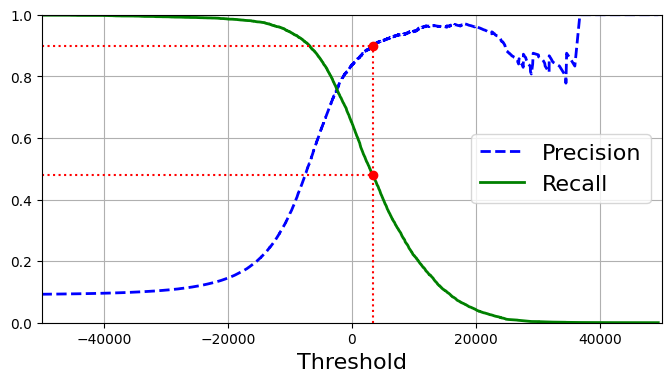

In [58]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
    plt.legend(loc='center right', fontsize=16) # Not shown in the book
    plt.xlabel('Threshold', fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], 'r:')                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], 'r:')                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], 'r:')# Not shown
plt.plot([threshold_90_precision], [0.9], 'ro')                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], 'ro')                             # Not shown
plt.show()

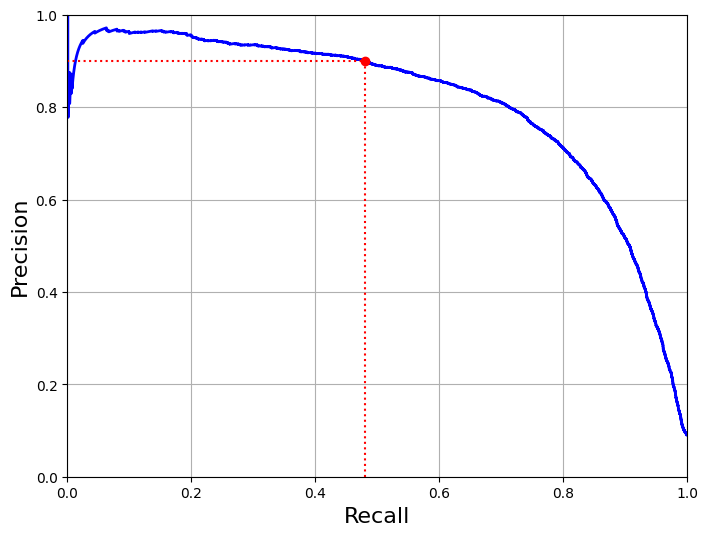

In [60]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], 'r:')
plt.plot([0.0, recall_90_precision], [0.9, 0.9], 'r:')
plt.plot([recall_90_precision], [0.9], 'ro')
plt.show()

So let’s suppose you decide to aim for 90% precision. You look up the first plot and find that you need to use a threshold of about 8,000. To be more precise you can search for the lowest threshold that gives you at least 90% precision

In [63]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [64]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [65]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. Hmm, not so fast. A high-precision classifier is not very useful if its recall is too low. If someone says “let’s reach 99% precision,” you should ask, “at what recall?”

## The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative.

In [66]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

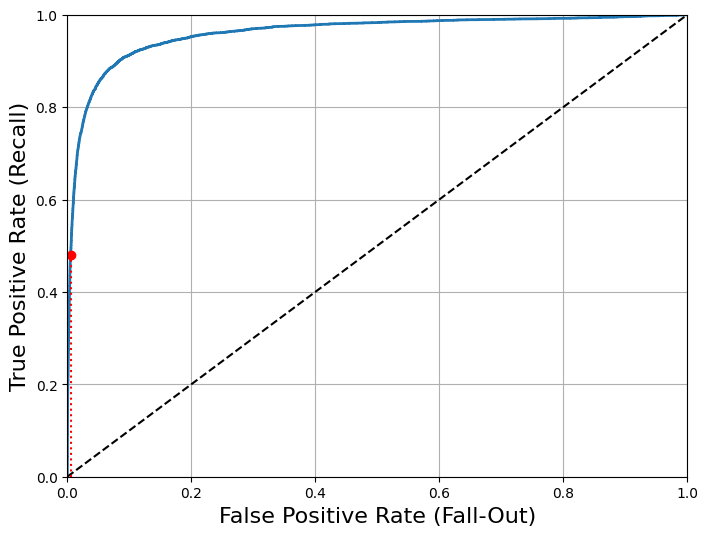

In [68]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], 'r:')   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], 'r:')  # Not shown
plt.plot([fpr_90], [recall_90_precision], 'ro')               # Not shown
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible. One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [69]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier.

In [75]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=43)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [82]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

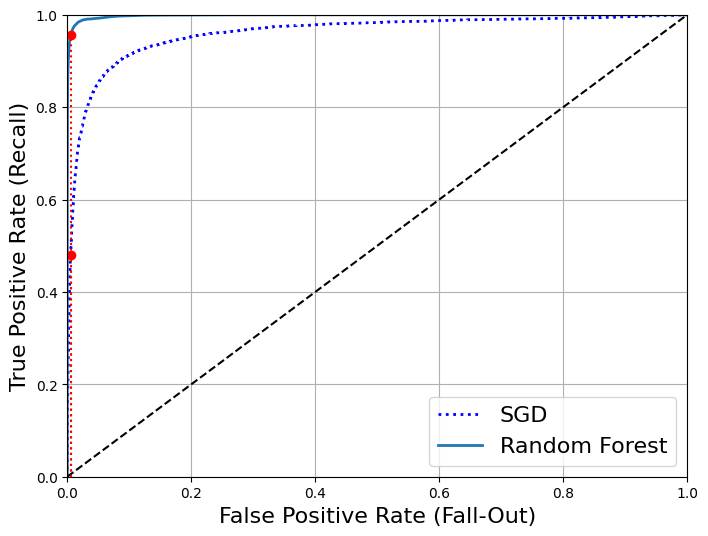

In [95]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b:', linewidth=2, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], 'r:')
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([fpr_90], [recall_90_precision], 'ro')
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], 'r:')
plt.plot([fpr_90], [recall_for_forest], 'ro')
plt.grid(True)
plt.legend(loc='lower right', fontsize=16)
plt.show()

In [85]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984888909627533

In [86]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9889028475711893

In [96]:
recall_score(y_train_5, y_train_pred_forest)

0.8712414683637705

This shows that the random forest classifier is a better model in this binary classification task.

# Multiclass Classification

One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-all (OvA) strategy (also called one-versus-the-rest). Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO).

In [98]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [103]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [105]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [110]:
len(ovo_clf.estimators_)

45

In [108]:
# Random Forest classifiers can directly classify instances into multiple classes
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [109]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.  , 0.1 , 0.  , 0.87, 0.  , 0.  , 0.02, 0.01]])

In [111]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

You can still do much better. For example, simply scaling the inputs increases accuracy.

In [112]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

# Error Analysis

Assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx